In [280]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import calendar
import statsmodels.api as sm
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [281]:
df = pd.read_csv("online_course_price_optimization_v2.csv")

df.head()

,date,price,ad_spend,enrollments,cost_per_enrollment,day_of_week,month
0,2024-01-01,109.93,95.85,0,5,0,1
1,2024-01-02,130.46,0.00,86,5,1,1
2,2024-01-03,90.73,86.03,159,5,2,1
3,2024-01-04,61.73,69.62,303,5,3,1
4,2024-01-05,129.31,93.23,111,5,4,1


## Inspection and Validation

In [282]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 365 non-null    object 
 1   price                365 non-null    float64
 2   ad_spend             365 non-null    float64
 3   enrollments          365 non-null    int64  
 4   cost_per_enrollment  365 non-null    int64  
 5   day_of_week          365 non-null    int64  
 6   month                365 non-null    int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 20.1+ KB


,price,ad_spend,enrollments,cost_per_enrollment,day_of_week,month
count,365.000000,365.000000,365.000000,365.0,365.000000,365.000000
mean,101.027781,90.805726,168.073973,5.0,2.991781,6.498630
std,19.262736,41.530118,91.723800,0.0,2.006155,3.448702
min,50.000000,0.000000,0.000000,5.0,0.000000,1.000000
25%,87.970000,74.290000,121.000000,5.0,1.000000,4.000000
50%,101.730000,95.850000,150.000000,5.0,3.000000,7.000000
75%,113.390000,117.180000,192.000000,5.0,5.000000,9.000000
max,150.000000,178.050000,1017.000000,5.0,6.000000,12.000000


In [283]:
df.duplicated().sum()

np.int64(0)

In [284]:
df.isnull().sum()

,0
date,0
price,0
ad_spend,0
enrollments,0
cost_per_enrollment,0
day_of_week,0
month,0


In [285]:
df.dtypes

,0
date,object
price,float64
ad_spend,float64
enrollments,int64
cost_per_enrollment,int64
day_of_week,int64
month,int64


In [286]:
df['date'] = pd.to_datetime(df['date'])

In [287]:
df['revenue'] = df['price'] * df['enrollments']
df['profit'] = (df['price'] - df['cost_per_enrollment']) * df['enrollments'] - df['ad_spend']

In [288]:
df

,date,price,ad_spend,enrollments,cost_per_enrollment,day_of_week,month,revenue,profit
0,2024-01-01,109.93,95.85,0,5,0,1,0.00,-95.85
1,2024-01-02,130.46,0.00,86,5,1,1,11219.56,10789.56
2,2024-01-03,90.73,86.03,159,5,2,1,14426.07,13545.04
3,2024-01-04,61.73,69.62,303,5,3,1,18704.19,17119.57
4,2024-01-05,129.31,93.23,111,5,4,1,14353.41,13705.18
...,...,...,...,...,...,...,...,...,...
360,2024-12-26,78.93,67.97,202,5,3,12,15943.86,14865.89
361,2024-12-27,134.21,96.87,113,5,4,12,15165.73,14503.86
362,2024-12-28,101.40,134.86,0,5,5,12,0.00,-134.86
363,2024-12-29,104.77,129.26,208,5,6,12,21792.16,20622.90


## EDA

#### Pairplots (Baisc and regression)

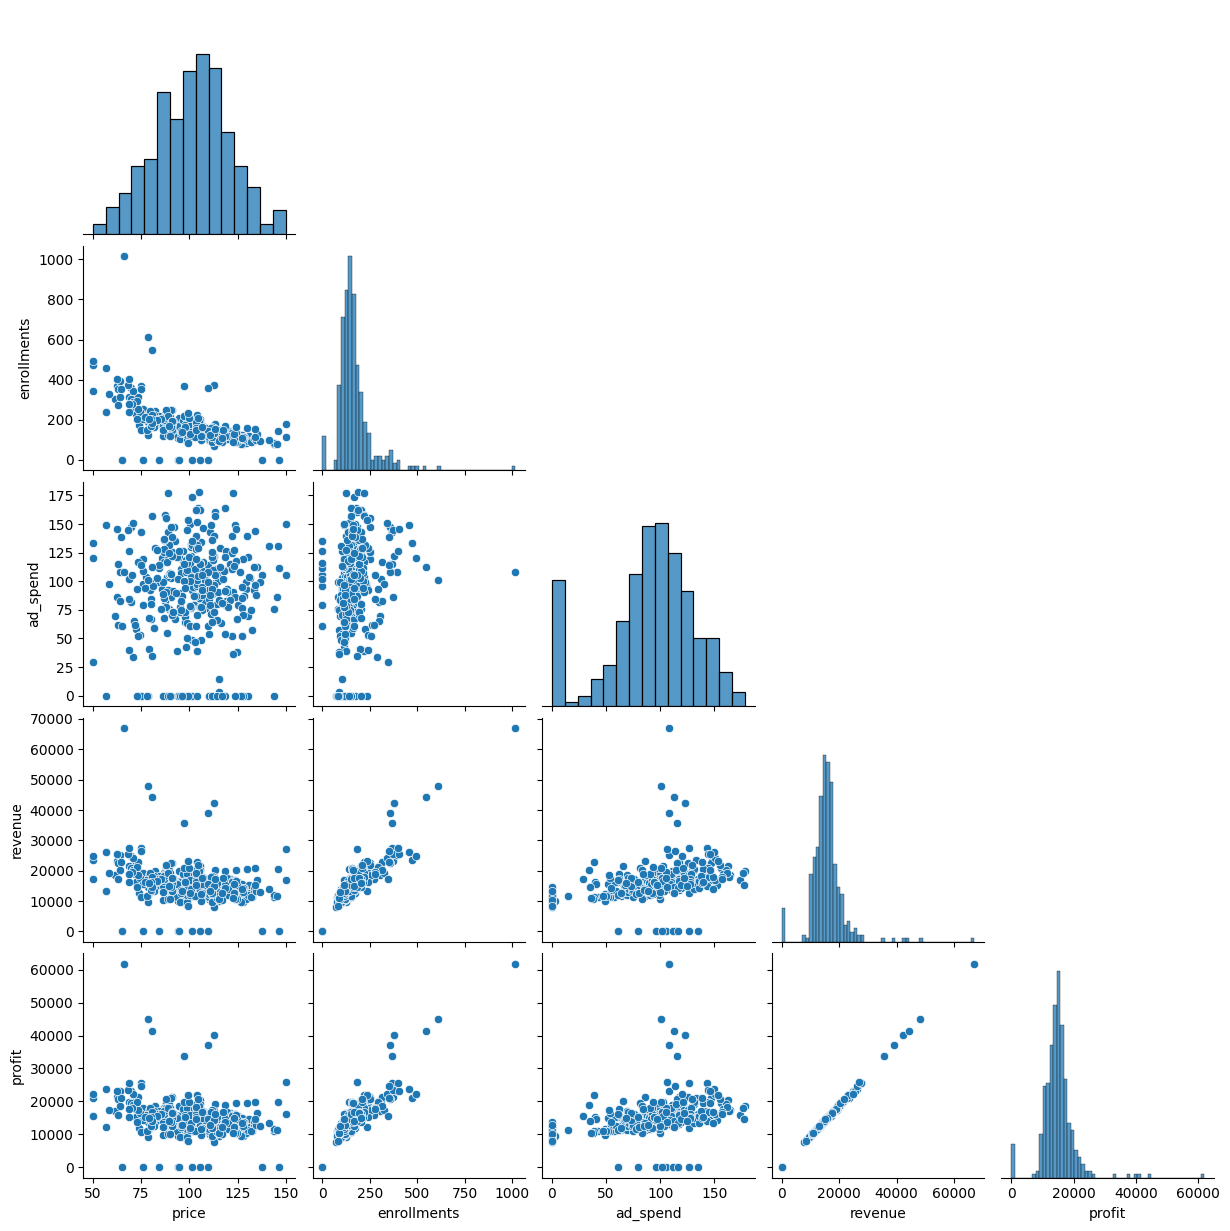

In [289]:
sns.pairplot(df[['price', 'enrollments', 'ad_spend', 'revenue', 'profit']], corner=True)

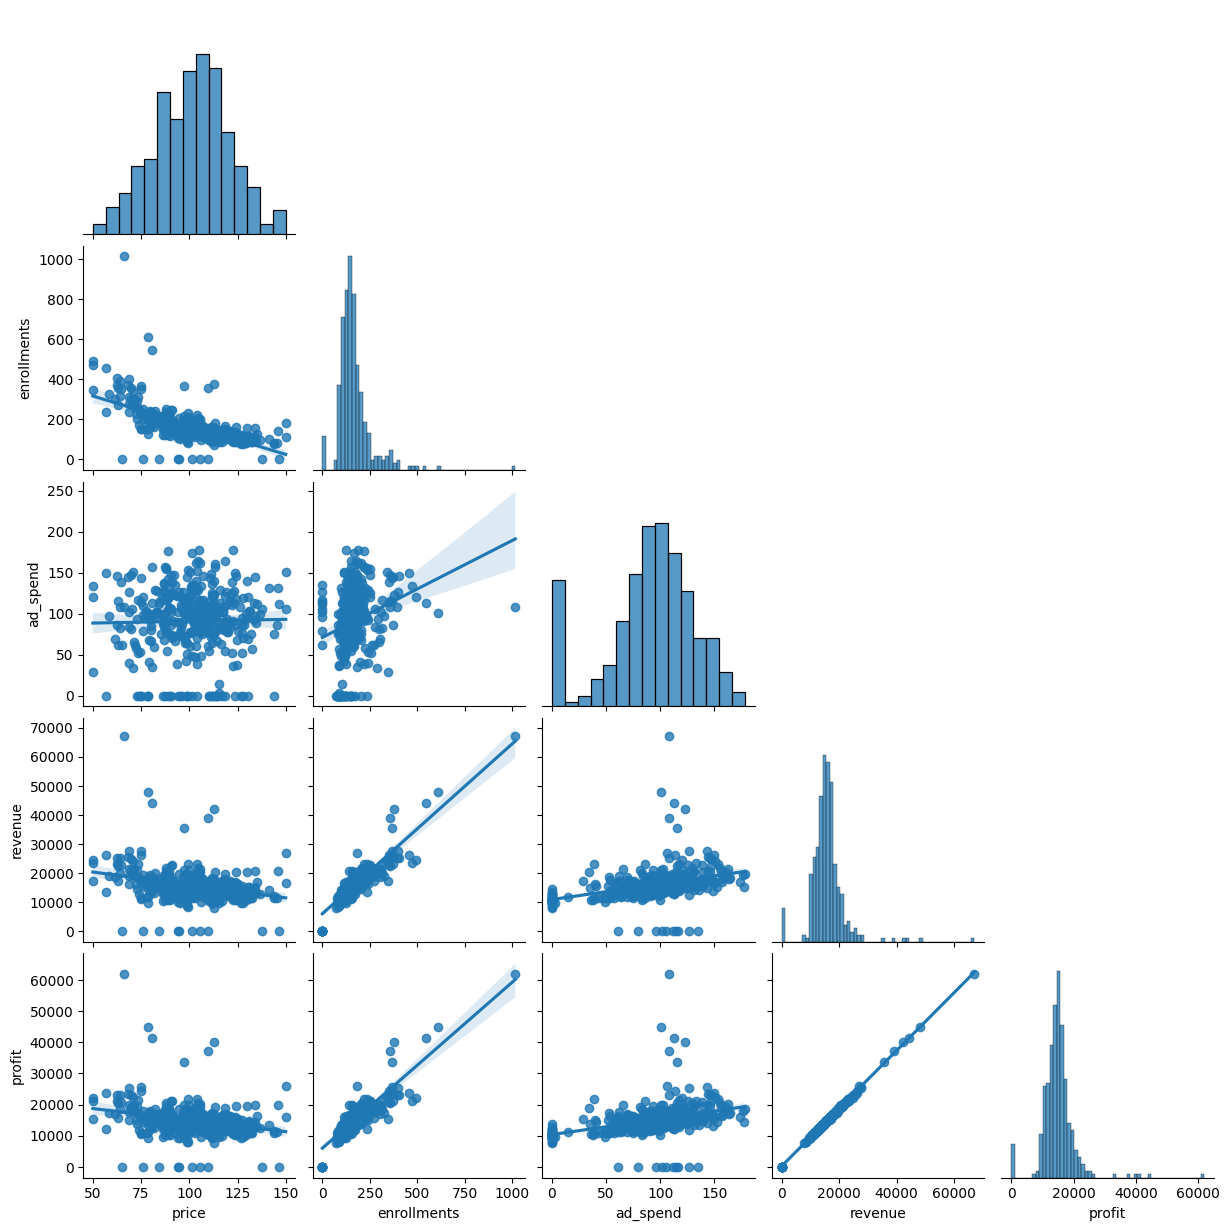

In [290]:
# pairplot with regression
sns.pairplot(df[['price', 'enrollments', 'ad_spend', 'revenue', 'profit']], kind="reg", corner=True)

<ipython-input-291-452320649>:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='day_of_week', y='enrollments', estimator='mean', ci=None)


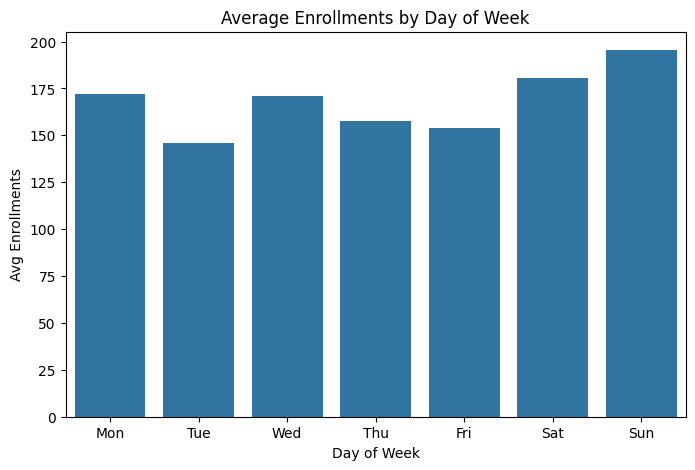

In [291]:
# Enrolment by weekdays (Average0)

day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='day_of_week', y='enrollments', estimator='mean', ci=None)
plt.xticks(ticks=range(7), labels=day_labels)
plt.title("Average Enrollments by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Avg Enrollments")
plt.show()

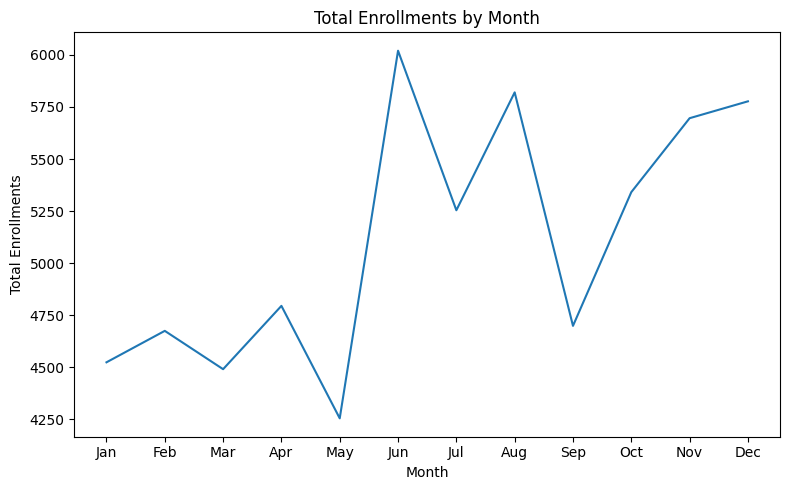

In [ ]:
# Enrolemtn by month
# Group and sort data
monthly = df.groupby('month')['enrollments'].sum().reset_index().sort_values('month')

plt.figure(figsize=(8, 5))
plt.plot(monthly['month'], monthly['enrollments'])
plt.title("Total Enrollments by Month")
plt.xlabel("Month")
plt.ylabel("Total Enrollments")
plt.xticks(ticks=monthly['month'], labels=calendar.month_abbr[1:])

plt.tight_layout()
plt.show()

## Summary
The pairplots show a negative relationship between price and enrollments - higher prices reduce demand.

Revenue appears to be slightly higher at lower prices, but the most volume seem to be at mid-range prices.

Profit is more scattered, indicating it's influenced by multiple factors other than just the price.

While enrollments are positively correlated with both revenue and profit, the relationship between ad spend and enrollments is weak.

Weekends show higher demand, Sunday has the highest average enrollments followed by Saturday with slightly less on Mondays. Tuesday and Friday have the lowest average enrollments.

Total enrollments vary across the year, with a noticeable spike in July, followed by high activity in September, December, and November. The lowest total enrollments occur in June, possibly due to seasonal disengagement or mid-year slowdown. Overall, the second half of the year tends to show stronger performance, which may be linked to learners preparing for the new year or end-of-year goals.

## Part 1: Price Elasticity and Demand Prediction
Linear regression


In [293]:
X = df[['price', 'ad_spend']]
y = df['enrollments']

# Add a constant term to include an intercept in the model
X = sm.add_constant(X)

# Fit the Ordinary Least Squares (OLS) regression model
model = sm.OLS(y, X).fit()

# View model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            enrollments   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     149.0
Date:                Sun, 15 Jun 2025   Prob (F-statistic):           6.11e-48
Time:                        19:59:04   Log-Likelihood:                -2057.2
No. Observations:                 365   AIC:                             4120.
Df Residuals:                     362   BIC:                             4132.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        411.0291     20.453     20.096      0.000     370.807     451.251
price         -2.9489      0.185    -15.907      0.000      -3.314      -2.584
ad_spend       0.6053      0.086      7.040      0.000       0.436       0.774
==============================================================================
Omnibus:                      362.714   Durbin-Watson:                   1.783
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27137.560
Skew:                           3.902   Prob(JB):                         0.00
Kurtosis:                      44.515   Cond. No.                         800.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Simulation and prediction


In [294]:
# Predictions
price_range = np.arange(50, 151)

# Use average ad spend for simulation
avg_ad_spend = df['ad_spend'].mean()


X_sim = pd.DataFrame({
    'price': price_range,
    'ad_spend': [avg_ad_spend] * len(price_range)
})
X_sim = sm.add_constant(X_sim, has_constant='add')



In [295]:
# Prediction
predicted_enrollments = model.predict(X_sim)

# Profit calculation
profit = (price_range - 5) * predicted_enrollments - avg_ad_spend


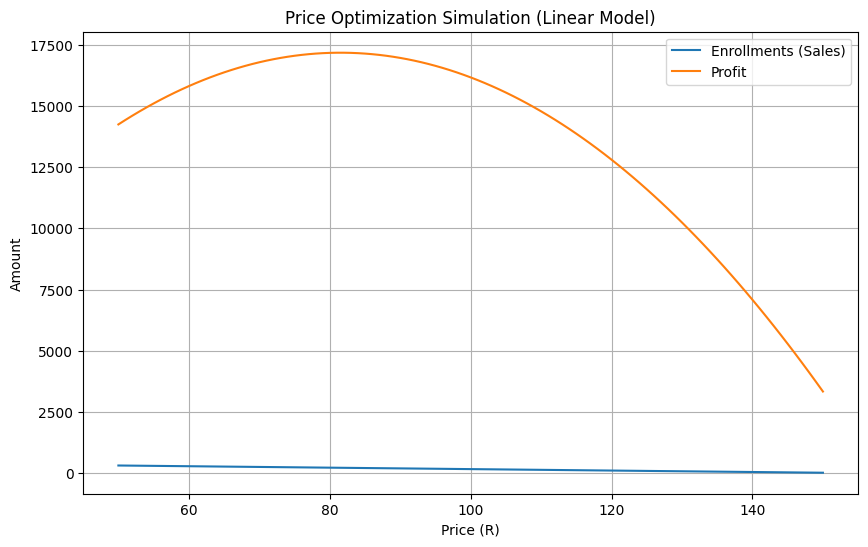

In [296]:
plt.figure(figsize=(10,6))
plt.plot(price_range, predicted_enrollments, label='Enrollments (Sales)')
plt.plot(price_range, profit, label='Profit')
plt.xlabel('Price (R)')
plt.ylabel('Amount')
plt.title('Price Optimization Simulation (Linear Model)')
plt.legend()
plt.grid(True)
plt.show()

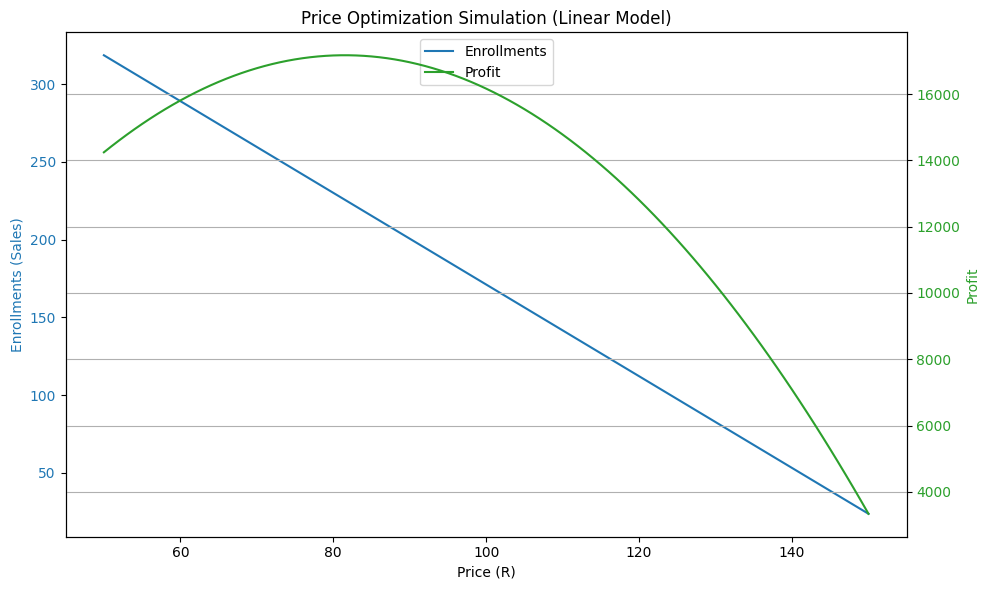

In [297]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# enrollments
color = 'tab:blue'
ax1.set_xlabel('Price (R)')
ax1.set_ylabel('Enrollments (Sales)', color=color)
ax1.plot(price_range, predicted_enrollments, color=color, label='Enrollments')
ax1.tick_params(axis='y', labelcolor=color)

# profit
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Profit', color=color)
ax2.plot(price_range, profit, color=color, label='Profit')
ax2.tick_params(axis='y', labelcolor=color)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center')

plt.title('Price Optimization Simulation (Linear Model)')
plt.grid(True)
plt.tight_layout()
plt.show()


## Part 2: Price Elasticity Modeling with Random Forest, XGBoost, and Gradient Boosting

In [298]:
# Features and target
X = df[['price', 'ad_spend', 'day_of_week', 'month']]
y = df['enrollments']

# One-hot encoding on categorical variables
categorical_features = ['day_of_week', 'month']
numeric_features = ['price', 'ad_spend']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical_features)
], remainder='passthrough')


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [299]:
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0)
}

results = {}

for name, model in models.items():
    pipe = Pipeline([
        ('preprocess', preprocessor),
        ('model', model)
    ])

    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    results[name] = {
        'MAE': mean_absolute_error(y_test, preds),
        'RMSE': np.sqrt(mean_squared_error(y_test, preds)),
        'R²': r2_score(y_test, preds)
    }

### Results from different models

In [300]:
results_df = pd.DataFrame(results).T
print(results_df.sort_values('RMSE'))

                         MAE       RMSE        R²
Random Forest      27.256301  51.939563  0.472822
Gradient Boosting  27.981228  53.448208  0.441753
XGBoost            29.558683  58.825967  0.323764


Random Forest performed the best in comparison to other models with the lowest RMSE and the highest R² score

## Simulation and prdiction

In [301]:
price_range = np.arange(50, 151)

avg_ad_spend = df['ad_spend'].mean()
mode_day = df['day_of_week'].mode()[0]   # Most common day
mode_month = df['month'].mode()[0]       # Most common month

sim_data = pd.DataFrame({
    'price': price_range,
    'ad_spend': [avg_ad_spend] * len(price_range),  # fix
    'day_of_week': mode_day,
    'month': mode_month
})

In [302]:
predicted_enrollments = models['Random Forest'].predict(
    preprocessor.transform(sim_data)
)

sim_data['enrollments'] = predicted_enrollments
sim_data['profit'] = (sim_data['price'] - 5) * sim_data['enrollments'] - avg_ad_spend

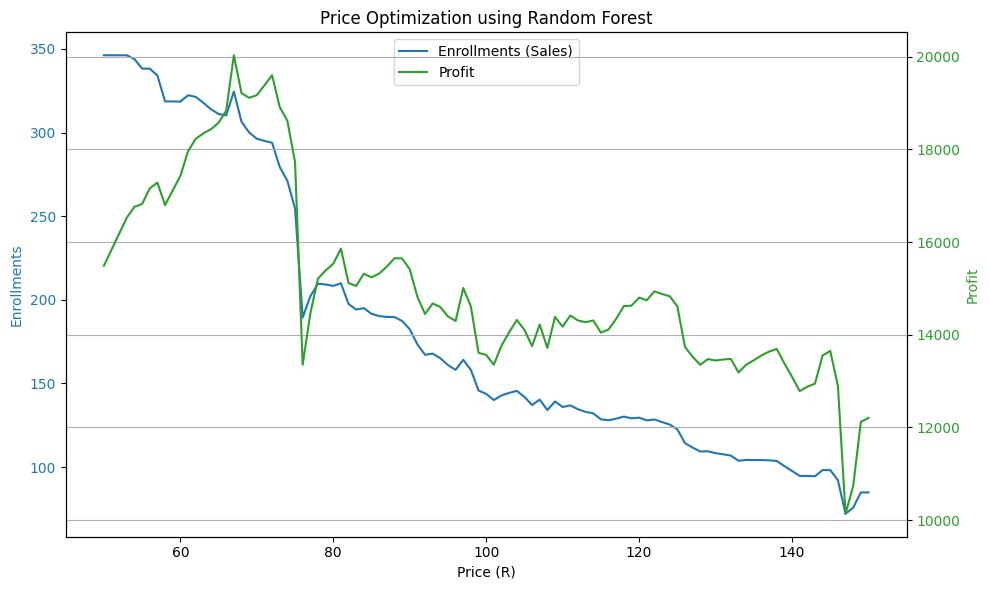

In [303]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Enrollments
color = 'tab:blue'
ax1.set_xlabel("Price (R)")
ax1.set_ylabel("Enrollments", color=color)
ax1.plot(sim_data['price'], sim_data['enrollments'], color=color, label='Enrollments (Sales)')
ax1.tick_params(axis='y', labelcolor=color)

# Profit
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel("Profit", color=color)
ax2.plot(sim_data['price'], sim_data['profit'], color=color, label='Profit')
ax2.tick_params(axis='y', labelcolor=color)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center')

plt.title("Price Optimization using Random Forest")
plt.grid(True)
plt.tight_layout()
plt.show()



In [304]:
# Find the price with highest enrollments and highest profit
max_enrollments_price = sim_data.loc[sim_data['enrollments'].idxmax(), 'price']
max_profit_price = sim_data.loc[sim_data['profit'].idxmax(), 'price']

### Optimal Price for sales/enrolments

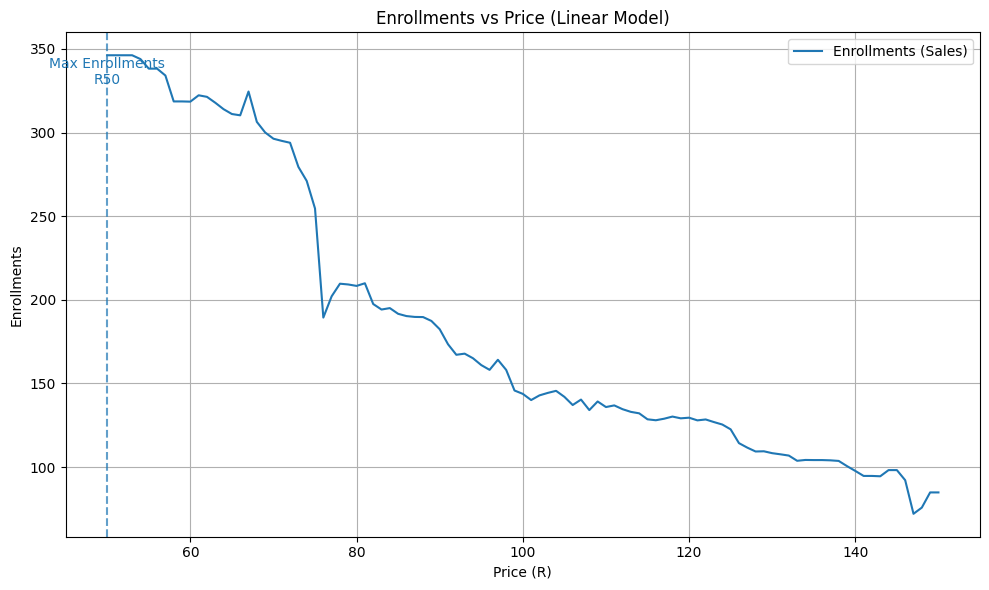

In [305]:
plt.figure(figsize=(10, 6))
plt.plot(sim_data['price'], sim_data['enrollments'], color='tab:blue', label='Enrollments (Sales)')
plt.axvline(x=max_enrollments_price, color='tab:blue', linestyle='--', alpha=0.7)
plt.text(max_enrollments_price, sim_data['enrollments'].max()*0.95,
         f'Max Enrollments\nR{max_enrollments_price}', color='tab:blue',
         ha='center')

plt.xlabel('Price (R)')
plt.ylabel('Enrollments')
plt.title('Enrollments vs Price (Linear Model)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### optimal Price for maximum pro+fit

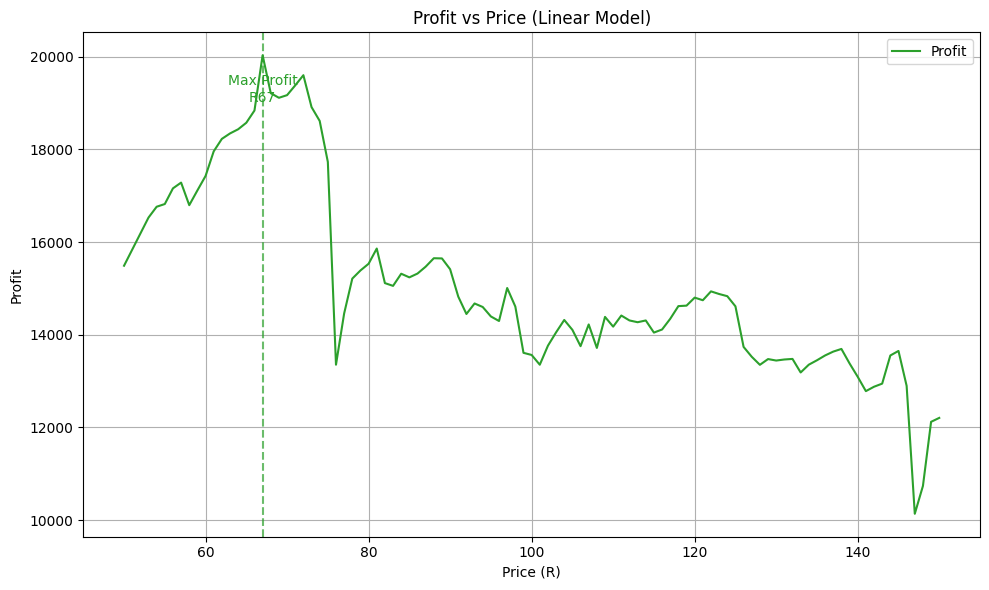

In [306]:
plt.figure(figsize=(10, 6))
plt.plot(sim_data['price'], sim_data['profit'], color='tab:green', label='Profit')
plt.axvline(x=max_profit_price, color='tab:green', linestyle='--', alpha=0.7)
plt.text(max_profit_price, sim_data['profit'].max()*0.95,
         f'Max Profit\nR{max_profit_price}', color='tab:green',
         ha='center')

plt.xlabel('Price (R)')
plt.ylabel('Profit')
plt.title('Profit vs Price (Linear Model)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Final Summary and insights

This project explored how pricing affects enrollments and profitability for an online course business. Using a machine learning model (Random Forest), I simulated enrollments and profit across a range of prices to identify the optimal price points under different business goals.

Price and enrollments are negatively correlated: as price increases, demand decreases.

Profit is maximized at a higher price than where enrollments peak.

Simulation trade-off: lower prices drive volume, while higher prices improve margins.

The optimal price for maximum profit (from the Random Forest model) is approximately R67.

The price that maximizes enrollments is around R50.

A balanced price near R60 could provide a compromise between growth and profitability.

Given a business goal of maximizing profit, R67 is recommended. However, if the focus shifts toward user acquisition or market growth, R50 may be more suitable.